# PN2V Prediction
Please run the `2_ProbabilisticNoise2VoidTraining.ipynb` notebook first.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread
import sys
sys.path.append('../../../')
from unet.model import UNet
from pn2v.utils import denormalize
from pn2v.utils import normalize
from pn2v.utils import PSNR
from pn2v import utils
from pn2v import prediction
import pn2v.training
from pn2v import histNoiseModel
from pn2v import gaussianMixtureNoiseModel

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [2]:
# We need the training data in order to calculate 'mean' and 'std' for normalization
path='../../../data/Convallaria_diaphragm/'

# Load the test data
dataTest=imread(path+"20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif")[:,:512,:512] 
# We are loading only a sub image to spped up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]

### Load the correct `namePN2VModel` and `dataName`

In [3]:
dataName = 'convallaria'# Use the same name as used in 2_ProbabilisticNoise2VoidTraining.ipynb. This is a part of model name created in ProbabilisticNoise2VoidTraining.ipynb
# Load the noiseModel of interest 
nameNoiseModel ='HistNoiseModel_'+dataName+'_'+'calibration'
# nameNoiseModel='GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'calibration'
# nameNoiseModel ='HistNoiseModel_'+dataName+'_'+'bootstrap'
# nameNoiseModel='GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'bootstrap'


In [4]:
namePN2VModel=nameNoiseModel
net=torch.load(path+"/last_"+namePN2VModel+".net")
if('HistNoiseModel' in namePN2VModel):
    histogram = np.load(path+nameNoiseModel+'.npy') 
    noiseModel= histNoiseModel.NoiseModel(histogram, device=device)
elif('GMMNoiseModel' in namePN2VModel):
    params= np.load(path+nameNoiseModel+'.npz')
    noiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(params = params, device = device)    

## Evaluation

image: 0
PSNR input 29.009240856174337
PSNR prior 35.59969564740663
PSNR mse 36.38770853570514
-----------------------------------
image: 1
PSNR input 29.018589127299936
PSNR prior 35.53913799312597
PSNR mse 36.326541316226354
-----------------------------------
image: 2
PSNR input 29.035458856560645
PSNR prior 35.59674513332879
PSNR mse 36.37554980569203
-----------------------------------
image: 3
PSNR input 28.990347509982925
PSNR prior 35.76946302727967
PSNR mse 36.59986678486526
-----------------------------------
image: 4
PSNR input 29.002852113680238
PSNR prior 35.80699794840622
PSNR mse 36.646083203428
-----------------------------------
image: 5
PSNR input 29.02402327393454
PSNR prior 35.75540170496831
PSNR mse 36.54793202320263
-----------------------------------
image: 6
PSNR input 29.032053580418268
PSNR prior 35.68964112019966
PSNR mse 36.504077442739394
-----------------------------------
image: 7
PSNR input 29.017435705343363
PSNR prior 35.60514042093785
PSNR mse 36.3718

image: 63
PSNR input 28.943605925782467
PSNR prior 35.71132820855858
PSNR mse 36.48557399156269
-----------------------------------
image: 64
PSNR input 28.984797176949073
PSNR prior 35.75188825777637
PSNR mse 36.55665753883027
-----------------------------------
image: 65
PSNR input 28.994764258029022
PSNR prior 35.78616764413021
PSNR mse 36.62303819218859
-----------------------------------
image: 66
PSNR input 28.974272339535343
PSNR prior 35.65542795596958
PSNR mse 36.42377863304803
-----------------------------------
image: 67
PSNR input 28.968391660007423
PSNR prior 35.75807381784766
PSNR mse 36.57155518284385
-----------------------------------
image: 68
PSNR input 28.930129735581886
PSNR prior 35.63305706375968
PSNR mse 36.429994295125766
-----------------------------------
image: 69
PSNR input 28.97258922282324
PSNR prior 35.778024328223815
PSNR mse 36.609025340468996
-----------------------------------
image: 70
PSNR input 28.917087395242863
PSNR prior 35.73651252871274
PSNR 

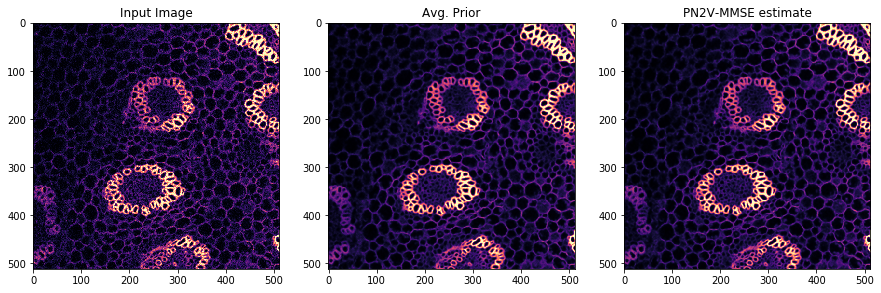

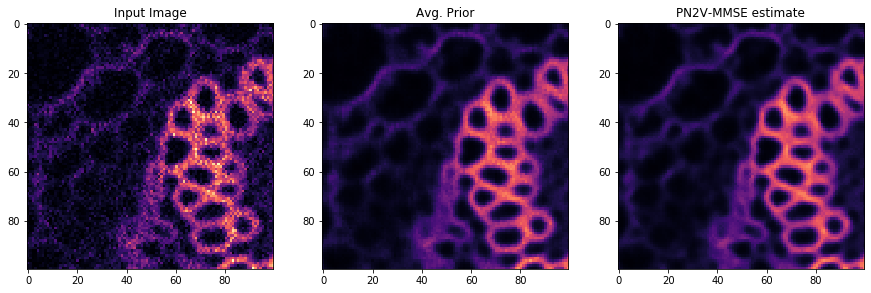

Avg PSNR Prior: 35.7187965890626 +-(2SEM) 0.02023083242797975
Avg PSNR MMSE: 36.52874744540184 +-(2SEM) 0.02397925163140744


In [6]:
# Now we are processing data and calculating PSNR values.
results=[]
meanRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    means, mseEst = prediction.tiledPredict(im, net ,ps=192, overlap=48,
                                            device=device, noiseModel=noiseModel)
    
    resultImgs.append(mseEst)
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    psnr=PSNR(gt, mseEst,rangePSNR )
    psnrPrior=PSNR(gt, means,rangePSNR )
    results.append(psnr)
    meanRes.append(psnrPrior)

    print ("image:",index)
    print ("PSNR input",PSNR(gt, im, rangePSNR))
    print ("PSNR prior",psnrPrior) # Without info from masked pixel
    print ("PSNR mse",psnr) # MMSE estimate using the masked pixel
    print ('-----------------------------------')

    
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst, vmax=vma, vmin=vmi, cmap='magma')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
#plt.imsave('../../../imgs/PN2V_BootHist.png', mseEst[100:200,150:250])
plt.show()

print("Avg PSNR Prior:", np.mean(np.array(meanRes) ), '+-(2SEM)',2*np.std(np.array(meanRes) )/np.sqrt(float(len(meanRes)) ) )
print("Avg PSNR MMSE:", np.mean(np.array(results) ),  '+-(2SEM)' ,2*np.std(np.array(results) )/np.sqrt(float(len(results)) ) )